In [1]:
from typing import List, Tuple, Set

import numpy as np
import matplotlib.pyplot as plt

%matplotlib widget

In [2]:
class Cell():
    def __init__(self, i : int, j : int, grid_size : int) -> None:
        self.location : Tuple[int] = (i, j)
        self.grid_size : int = grid_size

        self.spin : int = 0

    def nearest_neighbour_indicies(self, periodic : bool = True) -> Set[Tuple]:
        if periodic:
            left  = ((self.location[0]-1) % self.grid_size, self.location[1])
            right = ((self.location[0]+1) % self.grid_size, self.location[1])
            bot   = (self.location[0], (self.location[1]-1) % self.grid_size)
            top   = (self.location[0], (self.location[1]+1) % self.grid_size)

            return {left, right, bot, top}
        
    def __repr__(self) -> str:
        return (f"Cell {self.location}")

In [3]:
class Grid():
    def __init__(self, size : int, J = 0, h = 0, beta = 1) -> None:
        self.size : int = size

        self.steps = 0

        self.J = J
        self.h = h
        self.beta = beta

        self.cells : List[List[Cell]] = []

    def setup_cells(self) -> None:
        for i in range(self.size):
            self.cells.append([])
            for j in range(self.size):
                self.cells[i].append(Cell(i, j, self.size))

    def zero_cells(self) -> None:
        for row in self.cells:
            for cell in row:
                cell.spin = 0
    
    def randomise_cells(self) -> None:
        for row in self.cells:
            for cell in row:
                cell.spin = np.random.randint(0,2)

    def cell_neighbours(self, cell: Cell):
        neighbour_indicies = cell.nearest_neighbour_indicies()
        neighbour_cells = set()
        for n_idx in neighbour_indicies:
            neighbour_cells.add(self.cells[n_idx[0]][n_idx[1]])
        return neighbour_cells

    def _random_cell(self) -> Cell:
        """Give random cell"""
        return self.cells[np.random.randint(0, self.size)][np.random.randint(0, self.size)]
    
    def time_step(self) -> None:
        self.steps += 1

        cell = self._random_cell()
        neighbours = self.cell_neighbours(cell)
        total_neighbour_spin = np.sum([n.spin for n in neighbours])

        interaction_parameter = - self.J * total_neighbour_spin - self.h
        if cell.spin == 1: # up
            delta_energy = -2 * interaction_parameter
        elif cell.spin == 0: # down
            delta_energy = 2 * interaction_parameter

        if delta_energy < 0: # spin flip
            cell.spin = (cell.spin + 1) % 2
        else: # maybe flip
            probability = np.exp(-self.beta * delta_energy)
            if np.random.random() < probability: # thermal flip
                cell.spin = (cell.spin + 1) % 2


In [4]:
class State():
    def __init__(self, grid: Grid) -> None:
        self.spins = []
        for row in grid.cells:
            self.spins.append([cell.spin for cell in row])

        self.step = grid.steps

In [21]:
class Display():
    def __init__(self, grid: Grid, cols : int = 3) -> None:
        self.grid: Grid = grid

        self.state_store = []

        self.cols = cols

    def store_state(self) -> None:
        self.state_store.append(State(self.grid))

    def clear_storage(self) -> None:
        self.state_store = []

    def run_simulation(self, store_times) -> None:
        time_idx = 0
        current_time = store_times[0]

        is_done = False
        i = 1
        while not is_done:
            self.grid.time_step()

            if i == current_time:
                self.store_state()
                time_idx += 1
                if time_idx == len(store_times):
                    is_done = True
                else:
                    current_time = store_times[time_idx]

            i += 1

    def show(self) -> None:
        # get spin values
        spins = []
        for row in self.grid.cells:
            spins.append([cell.spin for cell in row])

        fig, ax = plt.subplots()
        ax.imshow(spins, 'gray')
        plt.show()

    def output_stored(self, reset : bool = False) -> None:
        fig, axs = plt.subplots(len(self.state_store) // self.cols, self.cols)
        
        for i, ax in enumerate(axs.flat[:len(self.state_store)]):
            state: State = self.state_store[i]
            ax.imshow(state.spins, 'gray')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(state.step)

        for ax in axs.flat[len(self.state_store):]:
            ax.axis('off')
        
        plt.show()

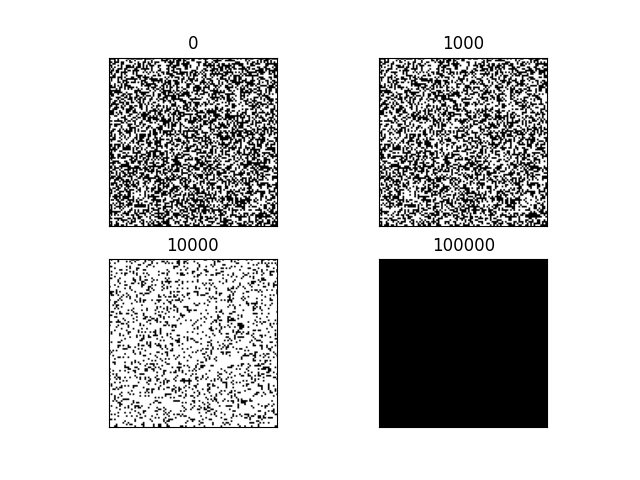

In [38]:
grid = Grid(
    size=100,
    J=0.3,
    h=0,
    beta=1e4
)
disp = Display(grid, 2)

grid.setup_cells()
grid.randomise_cells()
disp.store_state()

store_times = [1e3, 1e4, 1e5]
store_times.sort()

disp.run_simulation(store_times)

disp.output_stored()